# メッセージ パッシング

[Message Passing Tutorial — DGL 0.4 documentation](https://docs.dgl.ai/tutorials/basics/3_pagerank.html)

このチュートリアルでは、小規模なグラフ上に対して、PageRank アルゴリズムを用いて異なるレベルのメッセージ パッシング API の使い方を学びます。DGL では、メッセージ伝播や特徴量変形は **ユーザー定義の関数 (user-defined functions ;UDF)** によって自由に変えることが出来ます。

## PageRank アルゴリズム

PageRank は、各ノードに対する実数値の中心性 (PageRank 値という) を、PageRank が収束するまで逐次的に計算するアルゴリズムです。各イテレーションでは、すべてのノード (e.g. ウェブページ) は PageRank 値を周辺ノードに送信して、それから、反対に周辺ノードから収集した PageRank 値をもとに自身の PageRank を更新します。この更新式は次の通りです。

$$
 PV(u) = \frac{1-d}{N} + d \times \sum_{v \in \mathcal{N}(u)} \frac{PV(v)}{D(v)}
$$

ただし

- $N$ はノード数
- $D(v)$ はノード $v$ の次数 (degree)
- $\mathcal{N}(v)$ はノード $v$ の近傍ノード集合

## 単純な実装

`networkx` で適当な 100 ノードのグラフを作成し、`DGLGraph` に変換します。

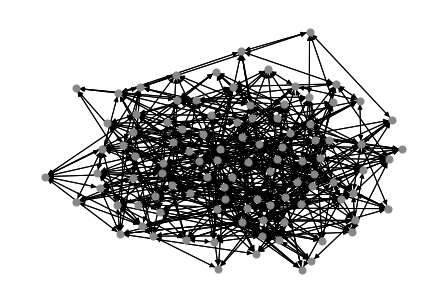

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl

N = 100
DAMP = 0.85
K = 10

g = nx.erdos_renyi_graph(N, 0.1)
g = dgl.DGLGraph(g)
nx.draw(g.to_networkx(), node_size=50, node_color='#888888')
plt.show()

アルゴリズムに基づけば、PageRank は典型的な scatter/gather パターンの 2 つのフェーズに落とし込むことが出来ます。PageRank の初期値としては `1/N` を利用して、その他にも次数を特徴量 (フィールド) として保存しておきます。

In [5]:
g.ndata['pv'] = torch.ones(N) / N
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

In [6]:
g.out_degrees(g.nodes()).float()

tensor([ 8., 11.,  8., 11.,  7.,  9.,  9., 13.,  9., 12.,  9., 12.,  9., 12.,
         7.,  7., 11.,  9., 17., 11.,  7., 11., 11., 10., 10., 10.,  7., 15.,
        16., 12., 11., 10.,  6.,  9.,  8.,  6.,  9.,  9., 14., 11.,  9., 12.,
        11.,  7.,  9.,  8.,  7.,  8., 10., 15.,  9., 11., 10., 10., 12.,  8.,
         8.,  5., 12.,  7.,  9.,  8., 10., 15., 14., 10., 13., 11.,  7.,  4.,
        10., 14., 10., 11.,  9.,  7.,  7., 10., 10., 12.,  8., 11., 11.,  7.,
         9., 11.,  8.,  9.,  6., 16.,  6.,  8., 10., 10.,  8.,  6., 12.,  5.,
        10.,  7.])

メッセージ関数 (scatter の実装) を定義します。メッセージ関数は、アルゴリズムの数式通りに PageRank 値を変形して、近傍ノードに流し込みます。 

In [7]:
def pagerank_message_func(edges):
    return {'pv' : edges.src['pv'] / edges.src['deg']}

DGL では、メッセージ関数はエッジに対する関数として表現されます。メッセージ関数のように、エッジ `edge` を入力とする関数を **Edge UDF** と呼びます。`edges` は次の 3 つのプロパティを持ちます。

- `src`: ソースノードの特徴量テンソル
- `dst`: 宛先ノードの特徴テンソル
- `data`: エッジの特徴テンソル

なお、上の `pagerank_message_func` ではソース ノードの特徴量しか使いませんでした。

次に、集約 (reduce) 関数を定義します。集約関数は `mailbox` に届いたメッセージを集計して、新しい PageRank 値を計算します。


In [8]:
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

今度は `nodes` の関数となっているように、`pagerank_reduce_func` は **Node UDF** の例です。Node UDF は、以下のプロパティを持つ `nodes` を入力とする関数です。

- `data`: ノードの特徴量
- `mailbox`: メッセージ関数で送信されてきたすべての特徴テンソル。あらたな軸にスタックされている

message UDF はエッジのバッチに対して動作する一方、reduce UDF もエッジのバッチに対して動作しますが、ノードのバッチを出力します。この関係を表したのが次の図です。

![](https://i.imgur.com/kIMiuFb.png)

UDF をコールバックとしてグラフに登録しておきます。

In [9]:
g.register_message_func(pagerank_message_func)
g.register_reduce_func(pagerank_reduce_func)

このアルゴリズムは非常に単純です。これは PageRank のイテレーションを 1 回行うコードの例です。

In [10]:
def pagerank_naive(g):
    # Phase #1: メッセージ関数を使って、すべてのエッジに対してメッセージを送信
    for u, v in zip(*g.edges()):
        g.send((u, v))
    # Phase #2: 集約関数を使って、送信されたメッセージを集約
    for v in g.nodes():
        g.recv(v)

## 大規模グラフのためのバッチ処理方法

上の実装では、すべてのノードごとにイテレーションが行われるので、スケールしません (大規模グラフでの実行速度が遅い)。この問題を回避するために、DGL はバッチ処理を実行する API を提供しています。内部的に、着信メッセージ数でのノードをグルーピングして、各グループごとに reduce を行うなどの工夫を行っています。

In [12]:
def pagerank_batch(g):
    g.send(g.edges())
    g.recv(g.nodes())

## 効率化のための高レベル API

`send` や recv` のような基本的な関数を組み合わせて実装できる API を提供する一方で、同じようなパターンが何回も現れる冗長性を省くために、さらに高いレベルの API を提供しています。これを使うと、先程の例はさらに次のように簡単に書くことが出来ます。

API の詳細はドキュメントを参照してください。

[dgl.DGLGraph — DGL 0.4 documentation](https://docs.dgl.ai/api/python/graph.html)

In [13]:
def pagerank_level2(g):
    g.update_all()

## DGL の `builtin` 関数でさらなる効率化

単純に特徴を送信したり、総和で集約したりするような、ありふれたパターンの UDF を予め DGL は API として提供します。詳しくは [dgl.function — DGL 0.4 documentation](https://docs.dgl.ai/api/python/function.html) にドキュメントがありますが、例えば、先程のコードは次のようにさらに書き下すことが出来ます。

In [14]:
import dgl.function as fn

def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

なお、`g` には既に message/reduce 関数が登録されていますが、`update_all` で引数に指定するとオーバーライドされます。

さらにビルトインの関数を使うことで、DGL は処理を最適化し、message/reduce を別々に指定すると冗長ないくつかの処理を融合することが出来ます。例えば、上の例では、`copy_src` は意味を成さないので処理がスキップされ、`sum` のみが内部的に計算されます。

最終的に PageRank アルゴリズムは次のように実行できます。


In [15]:
for k in range(K):
    # Uncomment the corresponding line to select different version.
    # pagerank_naive(g)
    # pagerank_batch(g)
    # pagerank_level2(g)
    pagerank_builtin(g)
print(g.ndata['pv'])

tensor([0.0086, 0.0110, 0.0085, 0.0112, 0.0075, 0.0091, 0.0094, 0.0128, 0.0094,
        0.0122, 0.0096, 0.0121, 0.0092, 0.0121, 0.0079, 0.0077, 0.0111, 0.0094,
        0.0163, 0.0111, 0.0075, 0.0112, 0.0110, 0.0102, 0.0103, 0.0101, 0.0076,
        0.0148, 0.0154, 0.0122, 0.0110, 0.0102, 0.0067, 0.0093, 0.0086, 0.0066,
        0.0095, 0.0097, 0.0136, 0.0112, 0.0095, 0.0121, 0.0110, 0.0078, 0.0093,
        0.0084, 0.0077, 0.0085, 0.0102, 0.0145, 0.0093, 0.0113, 0.0102, 0.0104,
        0.0118, 0.0086, 0.0085, 0.0058, 0.0120, 0.0075, 0.0093, 0.0085, 0.0103,
        0.0146, 0.0138, 0.0102, 0.0129, 0.0111, 0.0076, 0.0051, 0.0106, 0.0137,
        0.0104, 0.0110, 0.0093, 0.0075, 0.0075, 0.0102, 0.0106, 0.0121, 0.0086,
        0.0112, 0.0112, 0.0077, 0.0097, 0.0111, 0.0085, 0.0097, 0.0067, 0.0154,
        0.0065, 0.0084, 0.0102, 0.0102, 0.0086, 0.0067, 0.0119, 0.0062, 0.0102,
        0.0076])


ビルトイン関数のメリットとして、GPu 計算を高速化できることも挙げられます。

例えば、最初に示した PageRank のアルゴリズムは、隣接行列 $\mathbf{A}$ を用いて、次のような行列形式に書き直すことが出来ます。
$$
\mathbf{R}^{(k)} = \frac{1-d}{N} \mathbf{1} + d \mathbf{A}*\mathbf{R}^{(k-1)}
$$

一般に、現実世界の大規模グラフの隣接行列はスパースなので、上の数式は疎行列計算手法 (spMV) を用いて GPU 上で高速に計算することが出来ます。DGL でビルトイン関数を使っていると、このような最適化を自動的に検出し、適宜 spMV を利用するように構成してくれます。

最初の実験フェーズでは UDF による message/reduce 関数で、最終的なコードではなるべくビルトイン関数 `builtin` を使うようにするのが良いかと思います。